In [1]:
# import libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import random
import joblib
import cv2
import mediapipe as mp

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report


from helper import plot_single_hand, preprocess_landmarks, train_and_log_model

#mlflow setup
import mlflow
import mlflow.sklearn



%matplotlib inline

In [2]:
# read the data
df = pd.read_csv(r'dataset\hand_landmarks_data.csv')
df.head()

,x1,y1,z1,x2,y2,z2,x3,y3,z3,x4,...,x19,y19,z19,x20,y20,z20,x21,y21,z21,label
0,262.669968,257.304901,-3.649205e-07,257.417542,247.109055,0.004224,246.882957,241.716827,0.005798,236.384537,...,223.345093,255.490692,-0.020450,215.043365,258.114746,-0.024577,208.006393,259.608673,-0.026722,call
1,83.351778,346.059113,-2.345265e-07,81.925037,328.562347,-0.011102,90.080132,311.535248,-0.021096,95.641823,...,132.451618,341.794434,-0.038175,142.773582,342.829254,-0.037336,152.431698,343.015991,-0.036136,call
2,187.756977,260.235492,-2.417307e-07,195.460579,241.506035,-0.000184,207.259529,223.674339,-0.009687,215.413628,...,250.301010,268.602938,-0.044068,262.425133,271.276638,-0.040469,272.989952,272.272231,-0.038301,call
3,114.976696,331.594238,-1.233261e-07,114.503494,320.549957,-0.002824,116.636627,310.080994,-0.008911,117.685066,...,145.195450,329.357544,-0.027622,151.053200,329.712341,-0.027863,155.990364,329.548828,-0.027723,call
4,188.795288,141.727867,-1.622995e-07,188.520905,127.947464,-0.002884,191.982880,111.010563,-0.008115,192.552521,...,226.696396,132.263248,-0.025113,234.831741,130.684147,-0.024087,241.587769,128.477188,-0.023486,call


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25675 entries, 0 to 25674
Data columns (total 64 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   x1      25675 non-null  float64
 1   y1      25675 non-null  float64
 2   z1      25675 non-null  float64
 3   x2      25675 non-null  float64
 4   y2      25675 non-null  float64
 5   z2      25675 non-null  float64
 6   x3      25675 non-null  float64
 7   y3      25675 non-null  float64
 8   z3      25675 non-null  float64
 9   x4      25675 non-null  float64
 10  y4      25675 non-null  float64
 11  z4      25675 non-null  float64
 12  x5      25675 non-null  float64
 13  y5      25675 non-null  float64
 14  z5      25675 non-null  float64
 15  x6      25675 non-null  float64
 16  y6      25675 non-null  float64
 17  z6      25675 non-null  float64
 18  x7      25675 non-null  float64
 19  y7      25675 non-null  float64
 20  z7      25675 non-null  float64
 21  x8      25675 non-null  float64
 22

In [4]:
print(f"The number of null values are :{df.isna().sum().sum()}")

The number of null values are :0


In [5]:
df.describe()

,x1,y1,z1,x2,y2,z2,x3,y3,z3,x4,...,z18,x19,y19,z19,x20,y20,z20,x21,y21,z21
count,25675.000000,25675.000000,2.567500e+04,25675.000000,25675.000000,25675.000000,25675.000000,25675.000000,25675.000000,25675.000000,...,25675.000000,25675.000000,25675.000000,25675.000000,25675.000000,25675.000000,25675.000000,25675.000000,25675.000000,25675.000000
mean,201.958632,260.158527,1.272461e-07,202.517395,252.115322,-0.009465,202.862981,240.645966,-0.015946,203.025267,...,-0.024129,201.792374,227.455597,-0.033751,201.811275,227.802576,-0.032208,201.874802,227.807287,-0.028828
std,90.500333,76.533210,2.737932e-07,84.770933,75.384691,0.010376,80.412089,74.721921,0.013973,79.647588,...,0.015658,94.046497,77.231210,0.020453,93.664595,78.441253,0.020877,93.547017,79.963438,0.021136
min,-36.050926,45.722923,-2.029986e-06,7.184681,51.256840,-0.096630,25.114323,45.489950,-0.155846,23.446341,...,-0.201897,0.198635,20.146784,-0.286821,3.278137,32.158108,-0.286470,-4.537216,23.226204,-0.262047
25%,124.110329,205.815950,-5.243216e-08,130.535929,197.999625,-0.015199,136.711035,187.018583,-0.023020,138.905817,...,-0.030728,126.828913,172.720392,-0.042726,126.887403,172.345467,-0.041957,126.356627,172.083794,-0.039220
50%,199.667847,255.181793,1.497277e-07,199.979530,247.113892,-0.008737,200.092758,235.776978,-0.014231,200.482040,...,-0.020969,197.579865,221.781479,-0.029942,197.591736,222.381149,-0.028510,197.453270,222.485229,-0.025269
75%,266.428482,304.991663,2.989988e-07,261.147457,296.850769,-0.002783,255.876354,284.925993,-0.007134,254.622768,...,-0.013661,268.103920,273.190765,-0.019987,267.745743,274.196884,-0.017971,267.324657,275.805222,-0.014294
max,633.556020,781.674469,1.876254e-06,606.232386,751.869416,0.076365,598.541348,719.365010,0.094131,607.999801,...,0.031774,632.923029,779.419948,0.078105,638.134761,760.854103,0.104580,641.788521,760.554894,0.118668


In [6]:
print(df['label'].value_counts())

label
three2             1653
palm               1649
four               1634
ok                 1592
stop_inverted      1567
call               1506
peace_inverted     1497
stop               1482
rock               1458
three              1456
peace              1441
like               1436
two_up_inverted    1371
two_up             1343
dislike            1295
one                1263
mute               1087
fist                945
Name: count, dtype: int64


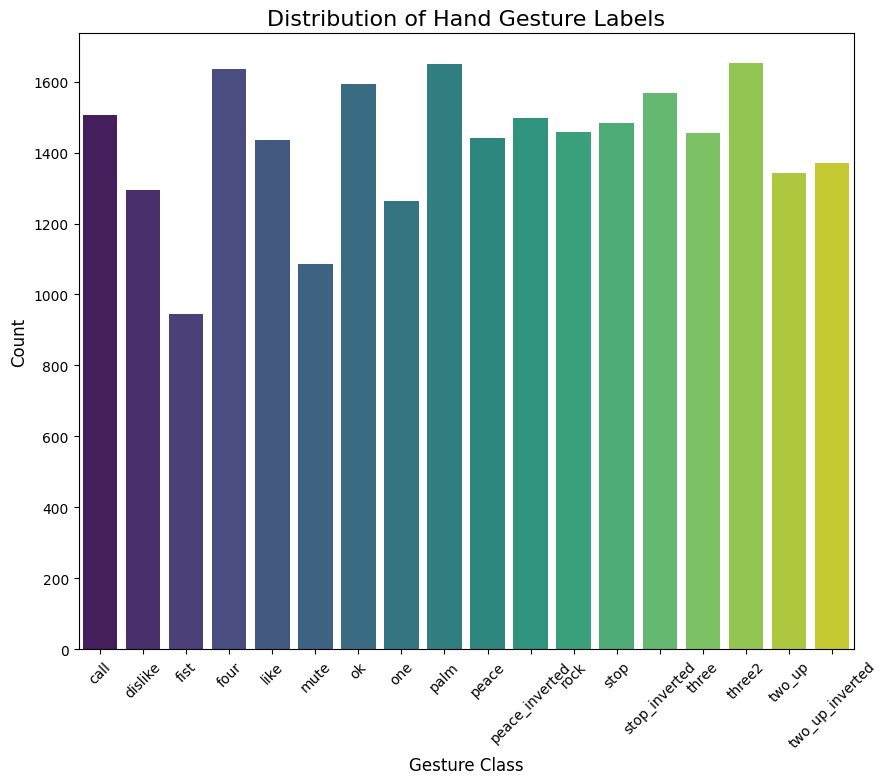

In [7]:
plt.figure(figsize=(10,8))

sns.countplot(x='label', 
              data=df, 
              palette='viridis',
              hue='label')
plt.title('Distribution of Hand Gesture Labels', fontsize=16)
plt.xlabel('Gesture Class', fontsize=12)
plt.ylabel('Count', fontsize=12)

plt.xticks(rotation=45)

plt.show()

In [8]:
data_sample = df.sample(1)
data_sample

,x1,y1,z1,x2,y2,z2,x3,y3,z3,x4,...,x19,y19,z19,x20,y20,z20,x21,y21,z21,label
24073,219.318039,173.023682,1.127342e-07,223.136505,169.916771,-0.005075,224.492828,165.043373,-0.007333,222.739288,...,215.827133,159.662441,-0.010751,216.836807,161.851936,-0.009855,217.526581,163.951,-0.007794,two_up


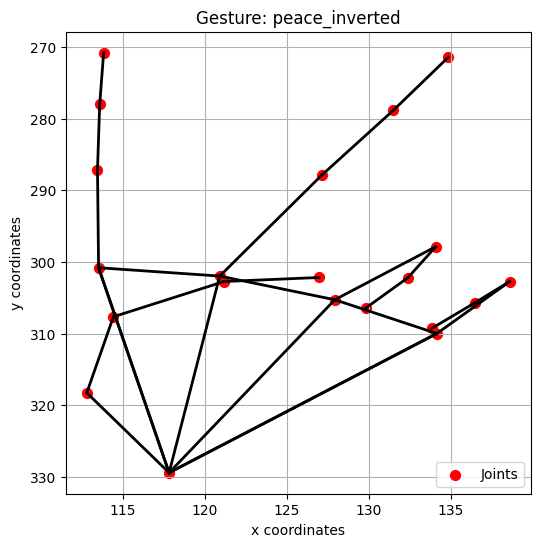

In [9]:
data_sample = df.sample(1)
target_label = data_sample['label'].values[0] 
features_raw = data_sample.drop('label', axis=1).values[0]
plot_single_hand(features_raw, label_name=target_label)

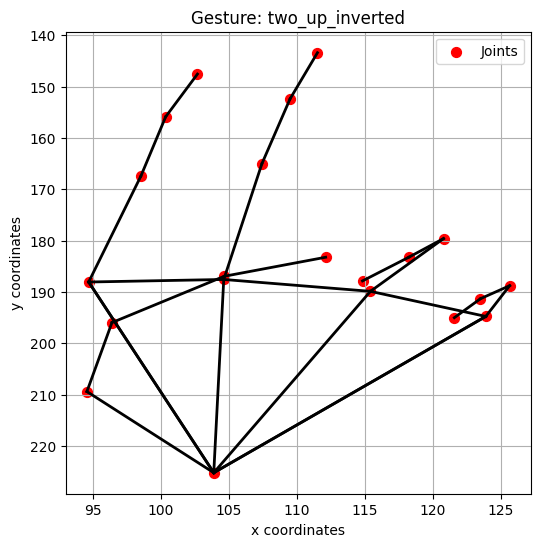

In [10]:
data_sample = df.sample(1)
target_label = data_sample['label'].values[0] 
features_raw = data_sample.drop('label', axis=1).values[0]
plot_single_hand(features_raw, label_name=target_label)

## Data preprocessing

In [11]:
print("Missing values before cleaning:", df.isnull().sum().sum())

Missing values before cleaning: 0


In [12]:
print("Shape before dropping the duplicates:", df.shape)
df_clean = df.drop_duplicates()
print("Shape after dropping the duplicates:", df_clean.shape)

Shape before dropping the duplicates: (25675, 64)
Shape after dropping the duplicates: (25675, 64)


In [13]:
X = df_clean.drop('label', axis=1).values
y = df_clean['label'].values

print(f"Features shape: {X.shape}, Labels shape: {y.shape}")

Features shape: (25675, 63), Labels shape: (25675,)


In [14]:
X_processed = np.apply_along_axis(preprocess_landmarks, 1, X)

## label endcoding

In [15]:
# Initialize Encoder
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)

# Print the mapping
print("Label Mapping:")
for i, label in enumerate(encoder.classes_):
    print(f"{i}: {label}")

Label Mapping:
0: call
1: dislike
2: fist
3: four
4: like
5: mute
6: ok
7: one
8: palm
9: peace
10: peace_inverted
11: rock
12: stop
13: stop_inverted
14: three
15: three2
16: two_up
17: two_up_inverted


In [16]:
X_train, X_test_validate, y_train, y_test_validate = train_test_split(
    X_processed, 
    y_encoded, 
    test_size=0.2, 
    random_state=42, 
    stratify=y_encoded
)

print(f"Training samples: {X_train.shape[0]}")
print(f"Testing samples: {X_test_validate.shape[0]}")

Training samples: 20540
Testing samples: 5135


In [17]:
X_validation, X_test, y_validation, y_test = train_test_split(
    X_test_validate, 
    y_test_validate, 
    test_size=0.5, 
    random_state=42, 
    stratify=y_test_validate
)

print(f"Validation samples: {X_validation.shape[0]}")
print(f"Testing samples: {X_test.shape[0]}")

Validation samples: 2567
Testing samples: 2568


In [18]:
# 1. Set the Experiment
mlflow.set_experiment("Hand_Gesture_Classification")

# Model 1: Random Forest
rf_params = {"n_estimators": 100, "max_depth": 6, "max_features": "sqrt", "max_leaf_nodes": 6}
rf_model = RandomForestClassifier(**rf_params, random_state=42)
train_and_log_model(rf_model, "Random_Forest",X_train, y_train, X_validation, y_validation, rf_params)

# Model 2: SVM
svm_params = {"C": 2, "gamma": "scale", "kernel": "rbf"}
svm_model = SVC(**svm_params, probability=True, random_state=42)
train_and_log_model(svm_model, "SVM", X_train, y_train, X_validation, y_validation, svm_params)

# Model 3: KNN
knn_params = {"n_neighbors": 7, "weights": "uniform"}
knn_model = KNeighborsClassifier(**knn_params)
train_and_log_model(knn_model, "KNN", X_train, y_train, X_validation, y_validation, knn_params)


2026/02/11 00:54:04 INFO alembic.runtime.plugins: setup plugin alembic.autogenerate.schemas
2026/02/11 00:54:04 INFO alembic.runtime.plugins: setup plugin alembic.autogenerate.tables
2026/02/11 00:54:04 INFO alembic.runtime.plugins: setup plugin alembic.autogenerate.types
2026/02/11 00:54:04 INFO alembic.runtime.plugins: setup plugin alembic.autogenerate.constraints
2026/02/11 00:54:04 INFO alembic.runtime.plugins: setup plugin alembic.autogenerate.defaults
2026/02/11 00:54:04 INFO alembic.runtime.plugins: setup plugin alembic.autogenerate.comments
2026/02/11 00:54:05 INFO alembic.runtime.migration: Context impl SQLiteImpl.
2026/02/11 00:54:05 INFO alembic.runtime.migration: Will assume non-transactional DDL.
d:\iti\Technical\projects\ML-Hand gesture\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf

Random_Forest - Accuracy: 0.6611, F1 Score: 0.5860, Precision: 0.5929, Recall: 0.6611


2026/02/11 00:55:16 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
d:\iti\Technical\projects\ML-Hand gesture\.venv\Lib\site-packages\mlflow\models\model.py:1209: FutureWarning: Saving scikit-learn models in the pickle or cloudpickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is the 'skops' format.
  flavor.save_model(path=local_path, mlflow_model=mlflow_model, **kwargs)


SVM - Accuracy: 0.9536, F1 Score: 0.9536, Precision: 0.9558, Recall: 0.9536


2026/02/11 00:55:36 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
d:\iti\Technical\projects\ML-Hand gesture\.venv\Lib\site-packages\mlflow\models\model.py:1209: FutureWarning: Saving scikit-learn models in the pickle or cloudpickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is the 'skops' format.
  flavor.save_model(path=local_path, mlflow_model=mlflow_model, **kwargs)


KNN - Accuracy: 0.9762, F1 Score: 0.9763, Precision: 0.9765, Recall: 0.9762


In [19]:
# train the model with knn and voting classifier
from sklearn.ensemble import VotingClassifier
knn_params = {"n_neighbors": 5, "weights": "uniform"}
knn_model = KNeighborsClassifier(**knn_params)

voting_model = VotingClassifier(estimators=[('rf', rf_model), ('svm', svm_model), ('knn', knn_model)], voting='soft')

train_and_log_model(voting_model, "Voting_Classifier", X_train, y_train, X_validation, y_validation, {"rf": rf_params, "svm": svm_params, "knn": knn_params})

2026/02/11 00:57:38 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
d:\iti\Technical\projects\ML-Hand gesture\.venv\Lib\site-packages\mlflow\models\model.py:1209: FutureWarning: Saving scikit-learn models in the pickle or cloudpickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is the 'skops' format.
  flavor.save_model(path=local_path, mlflow_model=mlflow_model, **kwargs)


Voting_Classifier - Accuracy: 0.9782, F1 Score: 0.9782, Precision: 0.9784, Recall: 0.9782


In [20]:
# train with xgboost
from xgboost import XGBClassifier
xgb_params = {"n_estimators": 100, "max_depth": 6, "learning_rate": 0.1, "subsample": 0.8, "colsample_bytree": 0.8}
xgb_model = XGBClassifier(**xgb_params, random_state=42)
train_and_log_model(xgb_model, "XGBoost", X_train, y_train, X_validation, y_validation, xgb_params)

2026/02/11 00:58:18 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
d:\iti\Technical\projects\ML-Hand gesture\.venv\Lib\site-packages\mlflow\models\model.py:1209: FutureWarning: Saving scikit-learn models in the pickle or cloudpickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is the 'skops' format.
  flavor.save_model(path=local_path, mlflow_model=mlflow_model, **kwargs)


XGBoost - Accuracy: 0.9817, F1 Score: 0.9817, Precision: 0.9819, Recall: 0.9817


In [21]:
# finetune the best model xgboost  
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

param_dist = {
    'n_estimators': [100, 200, 300, 500],        
    'learning_rate': [0.01, 0.05, 0.1, 0.2],     
    'max_depth': [3, 5, 7, 9],                 
    'gamma': [0, 0.1, 0.2, 0.5]                  
}

xgb_model = XGBClassifier(
    objective='multi:softmax',
    eval_metric='mlogloss',
    num_class=len(np.unique(y_train)),
    random_state=42)

grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_dist, cv=3, n_jobs=-1, verbose=2, scoring='accuracy')

# 3. Run Training and Log EVERYTHING
mlflow.set_experiment("XGBoost_FineTuning_Detailed")

print("Starting Grid Search... (This matches every combination)")

with mlflow.start_run(run_name="Parent_GridSearch_Run") as parent_run:
    
    # A. Fit the Grid Search (This takes time!)
    grid_search.fit(X_train, y_train)
    
    print("Grid Search Complete. Logging results to MLflow...")

    # B. Log the Best Result to the Parent Run
    mlflow.log_params(grid_search.best_params_)
    mlflow.log_metric("best_accuracy_cv", grid_search.best_score_)
    
    # Evaluate on Validation Set (Final Check)
    best_model = grid_search.best_estimator_
    val_acc = best_model.score(X_validation, y_validation)
    mlflow.log_metric("validation_accuracy", val_acc)
    
    mlflow.sklearn.log_model(best_model, "best_model")

    # C. ITERATE AND LOG EVERY COMBINATION (The "Child Runs")
    # cv_results_ contains arrays of all params and scores
    results = grid_search.cv_results_
    
    for i in range(len(results['params'])):
        params = results['params'][i]
        mean_score = results['mean_test_score'][i]
        std_score = results['std_test_score'][i]
        rank = results['rank_test_score'][i]
        
        # Start a Nested Run (Child of the main run)
        with mlflow.start_run(run_name=f"Trial_{i}", nested=True):
            mlflow.log_params(params)
            mlflow.log_metric("accuracy_cv", mean_score)
            mlflow.log_metric("std_cv", std_score)
            mlflow.log_metric("rank", rank)

    print(f"\n🏆 Best Validation Accuracy: {val_acc:.4f}")
    print(f"Best Params: {grid_search.best_params_}")


Starting Grid Search... (This matches every combination)
Fitting 3 folds for each of 256 candidates, totalling 768 fits
Grid Search Complete. Logging results to MLflow...


2026/02/11 03:49:10 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
d:\iti\Technical\projects\ML-Hand gesture\.venv\Lib\site-packages\mlflow\models\model.py:1209: FutureWarning: Saving scikit-learn models in the pickle or cloudpickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is the 'skops' format.
  flavor.save_model(path=local_path, mlflow_model=mlflow_model, **kwargs)



🏆 Best Validation Accuracy: 0.9852
Best Params: {'gamma': 0, 'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 500}
